# Sample loss characterization
To test for demographic and psychological sample selection biases we compared the excluded and low-completion rate groups to the core sample on several psychological and demographic measures. 

Pysch: STAI, BDI-II, NEO (5 subscales)

Dem: age, political orientation, income, race/ethnicity, education

To test for significant differences with in these measures we bootstrapped 10000 exluded/ low completion rate samples from core-sample participants and compared the true mean values (psych measures) and true eucledian distances (dem. measures) to teh bootstrapped null distributions. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
sns.axes_style("whitegrid")
from matplotlib.lines import Line2D
import os
from datetime import datetime
import nbimporter
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib
import time
from scipy.spatial.distance import cdist

# load demographic data

In [2]:
data_dir = os.path.join('..','..','data')
# core sample
core_data =  pd.read_csv(os.path.join(data_dir, 'core_dem.csv'), dtype = str)
# excluded sample
excluded_data =  pd.read_csv(os.path.join(data_dir, 'excluded_dem.csv'), dtype = str)
# low completion sample
lowCompl_data =  pd.read_csv(os.path.join(data_dir, 'lowCompl_dem.csv'), dtype = str)

# sampel sizes
N_core = len(core_data.PROLIFIC_PID.unique())
N_excl = len(excluded_data.PROLIFIC_PID.unique())
N_lowComl = len(lowCompl_data.PROLIFIC_PID.unique())


# cast age to numeric
core_data['prlfc_dem_age'] = pd.to_numeric(core_data['prlfc_dem_age'])
excluded_data['prlfc_dem_age'] = pd.to_numeric(excluded_data['prlfc_dem_age'])
lowCompl_data['prlfc_dem_age'] = pd.to_numeric(lowCompl_data['prlfc_dem_age'])



# load pysch data

In [3]:
boxDir=os.path.expanduser('~/Box/')
data_dir = boxDir + 'COVID-19 Adolphs Lab/PreProcessed_Data/'
listdir = boxDir + 'COVID-19 Adolphs Lab/participant_lists/'


# all data
data = pd.read_csv(data_dir + 'Wave1-16_A-M_release.csv', dtype=str, keep_default_na=False, na_values=['','NA'])
col_vars_w1 = ['PROLIFIC_PID', 'STAI_Trait_Tscore', 'NEO_O_z-score', 'NEO_C_z-score', 'NEO_E_z-score', 'NEO_A_z-score', 'NEO_N_z-score']
col_vars_w2 = ['PROLIFIC_PID', 'BDI_total_raw']


w1data = data.loc[data.wave == '1', col_vars_w1].copy()
w2data = data.loc[data.wave == '2', col_vars_w2].copy()
psych_data = w1data.merge(w2data, on = 'PROLIFIC_PID', how = 'outer')

# participant lists
core_sample = pd.read_csv(listdir + 'core_sample_prlfc.csv')
lowCompl_sample = pd.read_csv(listdir + 'low_compl_sample_prlfc.csv')
excl_sample = pd.read_csv(listdir + 'excl_sample_prlfc.csv')
core_PID = list(core_sample.PROLIFIC_PID)
lowCompl_PID = list(lowCompl_sample.PROLIFIC_PID)
excl_PID = list(excl_sample.PROLIFIC_PID)

core_psych = psych_data.loc[psych_data.PROLIFIC_PID.isin(core_PID), :].reset_index(drop = True)
excl_psych = psych_data.loc[psych_data.PROLIFIC_PID.isin(excl_PID), :].reset_index(drop = True)
lowCompl_psych = psych_data.loc[psych_data.PROLIFIC_PID.isin(lowCompl_PID), :].reset_index(drop = True)
del psych_data


# sample counts

In [4]:
data = data.loc[data.wave != '15b', :]
data = data.loc[~data.PROLIFIC_PID.str.startswith('CC'), :]
w1_incl = pd.DataFrame(data.PROLIFIC_PID.unique())
w2_incl = pd.read_csv(listdir + 'w2_included.csv',header=None)
w3_incl = pd.read_csv(listdir + 'w3_includeList_postw2_analysis.csv',header=None)
w4_incl = pd.read_csv(listdir + 'w4_includeList_postw3_analysis.csv',header=None)
w5_incl = pd.read_csv(listdir + 'w5_includeList_postw4_analysis.csv',header=None)
w6_incl = pd.read_csv(listdir + 'w6_includeList_postw5_analysis.csv',header=None)



sample_count = pd.DataFrame()
sample_count['wave'] = data.wave.unique()
sample_count.set_index('wave', inplace = True, drop = True)
sample_count.loc['1', 'invited'] = 1831
sample_count.loc['2', 'invited'] = len(w2_incl)
sample_count.loc['3', 'invited'] = len(w3_incl)
sample_count.loc['4', 'invited'] = len(w4_incl)
sample_count.loc['5', 'invited'] = len(w5_incl)
sample_count.loc['6', 'invited'] = len(w6_incl)


for i_wave in range(7,17):
    sample_count.loc[str(i_wave), 'invited'] = len(w5_incl)

# true completion 
sample = pd.DataFrame()
sample['PID'] = data.PROLIFIC_PID.unique()
sample.set_index('PID', inplace = True, drop = True)

for i_wave in data.wave.unique():
    tmp_pids = data.loc[data.wave == i_wave, 'PROLIFIC_PID'].unique()
    sample['wave_'+i_wave] = 0
    sample.loc[tmp_pids, 'wave_'+i_wave] = 1
    
sample['core_sample'] = 0
sample.loc[core_PID, 'core_sample'] = 1
sample['excl_sample'] = 0
sample.loc[excl_PID, 'excl_sample'] = 1
sample['low_compl_sample'] = 0
sample.loc[lowCompl_PID, 'low_compl_sample'] = 1

for i_wave in data.wave.unique():
    sample_count.loc[i_wave, 'core']=sample.loc[sample.core_sample == 1, 'wave_'+i_wave].sum()
    sample_count.loc[i_wave, 'low_compl']=sample.loc[sample.low_compl_sample == 1, 'wave_'+i_wave].sum()
    sample_count.loc[i_wave, 'excl_compl']=sample.loc[sample.excl_sample == 1, 'wave_'+i_wave].sum()
    
sample_count.loc[:, 'excluded'] = 0
sample_count.loc['1', 'excluded'] = len(set(w1_incl[0]) - set(w2_incl[0]))
sample_count.loc['2', 'excluded'] = len(set(w2_incl[0]) - set(w3_incl[0]))
sample_count.loc['3', 'excluded'] = len(set(w3_incl[0]) - set(w4_incl[0]))
sample_count.loc['4', 'excluded'] = len(set(w4_incl[0]) - set(w5_incl[0]))
sample_count.loc['5', 'excluded'] = len(set(w5_incl[0]) - set(w6_incl[0]))

# bootstrap functions

In [5]:
def independent_shuffle(arr):
    """"
    Shuffle arr's rows independently 
    """
    x, y = arr.shape
    rows = np.indices((x,y))[0]
    cols = [np.random.permutation(y) for _ in range(x)]
    return arr[rows, cols]


def bootsrapped_samples(core_vec, sample_size, N_samples = 1000):
    """
    Returns a bootstrapped set of N_samples samples with size = sample_size
    drawn from the core data. 
    Args.:
    core_vec (pd.Series): data column from the core sample
    sample_size (int): size of a bootstraped sample
    N_samples (int): number of boostrapped samples
    
    Returns:
    sampled_data (np.array) 
    
    """ 
    core_vec = np.array(core_vec)
    
    # repeat core data N_samples times
    sampled_data = np.tile(core_vec, (N_samples, 1))
    
    # shuffle sampled data
    sampled_data = independent_shuffle(sampled_data)
    
    # cut sampled data to sample_size
    sampled_data = sampled_data[:,:sample_size]
    
    return sampled_data

    
def prop_age_bins(age_array):
    """
    Takes array of age-values, bins ages into ACS age bracktes
    and returns the distribution across age brackets in % for each column.
    Args.:
    age_array (np.array): 1d
    
    Returns:
    age_array_prop (pd.Dataframe): distribution across age categories in % 
    age_array_count (pd.Dataframe): count of participants in each ege categories
    """ 
    
    # ACS age brackets
    age_bins = np.array(range(15,85,5))
    # categorize ages into age brackets
    age_array = np.digitize(age_array, age_bins).T
    # relable age brackets semantically
    age_array = pd.DataFrame(age_array).replace({1: '18-19', 2: '20-24', 3: '25-29', 4: '30-34',
                                              5: '35-39', 6: '40-44', 7:'45-59', 8: '50-54',
                                              9: '55-59', 10: '60-64', 11: '65-69', 12: '70-74',
                                              13: '75-79',14: '80-84'})
 
    # count occurance of each age-bracket per column
    age_array = age_array.melt(var_name='columns', value_name='index')
    age_array_count = pd.crosstab(index=age_array['index'], columns=age_array['columns'])
    # normalize count to percentage
    age_array_prop = (age_array_count/age_array_count.sum())*100
    
    # fix index across all iterations
    age_dist_df = pd.DataFrame(index=['18-19','20-24', '25-29','30-34','35-39', '40-44','45-59', 
                                  '50-54','55-59', '60-64', '65-69', '70-74','75-79','80-84'])
    age_array_prop = pd.concat([age_dist_df,age_array_prop], axis = 1)
    age_array_count = pd.concat([age_dist_df,age_array_count], axis = 1)
    
    # return distribution across age brackets in %
    age_array_prop.fillna(0, inplace=True)
    age_array_count.fillna(0, inplace=True)
    return age_array_prop, age_array_count                        
        
    
def prop_poli(poli_array):
    """
    Takes array of political affiliation-values, recodes semantically,
    and returns the distribution across political categories in %.
    Args.:
    poli_array (np.array): 1d
    
    Returns:
    poli_array_prop (pd.Dataframe): distribution across political categories in % 
    poli_array_count (pd.Dataframe): count of participants in each political categories
    """ 
    
    # re-lable party ID  semantically
    poli_array = pd.DataFrame(poli_array).replace({'1.0':'Republican', '2.0':'Democrat', 
                                                   '3.0':'Independant', '4.0':'Other'})
    if poli_array.shape[1]>1:
        poli_array = poli_array.T  
    # count occurance of each age-bracket per column
    poli_array = poli_array.melt(var_name='columns', value_name='index')
    poli_array_count = pd.crosstab(index=poli_array['index'], columns=poli_array['columns'])
    # normalize count to percentage
    poli_array_prop = (poli_array_count/poli_array_count.sum())*100
    
    # fix index across all iterations
    poli_dist_df = pd.DataFrame(index=['Republican','Democrat', 
                                  'Independant', 'Other'])
    poli_array_prop = pd.concat([poli_dist_df,poli_array_prop], axis = 1)

    # return distribution across age brackets in %
    poli_array_prop.fillna(0, inplace=True)
    return poli_array_prop, poli_array_count                        
            

def prop_raceEth(raceEth_array):
    """
    Takes array of race/ethnicity-values, recodes semantically,
    and returns the distribution across race/ethnicity categories in %.
    Args.:
    raceEth_array (np.array): 1d
    
    Returns:
    raceEth_array_prop(pd.Dataframe): distribution across race/ethnicity categories in % 
    raceEth_array_count(pd.Dataframe): count of participants in each race/ethnicity categories
    """ 
    
    # init output 
    raceEth_array_prop = pd.DataFrame(index=['American Indian/Alaska Native', 'Asian', 'Hispanic',
                                             'Native Hawaiian or Other Pacific Islander', 
                                             'Black or African American', 'White', 'Multiracial', 
                                             'Other', 'Prefer not to disclose'])
    # re-lable race/ethnicity  semantically
    raceEth_array = pd.DataFrame(raceEth_array).replace({'1.0': 'American Indian/Alaska Native', '2.0' : 'Asian',
                                                         '3.0': 'Native Hawaiian or Other Pacific Islander', 
                                                         '4.0':'Black or African American', '5.0':'White', 
                                                         '6.0':'Multiracial', '7.0' :'Other', 
                                                         '8.0': 'Prefer not to disclose', '9.0':'Hispanic'})
    if raceEth_array.shape[1]>1:
        raceEth_array = raceEth_array.T  
    # count occurance of each age-bracket per column
    raceEth_array = raceEth_array.melt(var_name='columns', value_name='index')
    raceEth_array_count = pd.crosstab(index=raceEth_array['index'], columns=raceEth_array['columns'])
    # normalize count to percentage
    raceEth_dist_df = (raceEth_array_count/raceEth_array_count.sum())*100                                            
    
    # fix index across all iterations
    raceEth_array_prop = pd.concat([raceEth_array_prop,raceEth_dist_df], axis = 1)

    # return distribution across age brackets in %
    raceEth_array_prop.fillna(0, inplace=True)
    return raceEth_array_prop, raceEth_array_count   
 
def prop_education(education_array):
    """
    Takes array of education-values, recodes semantically,
    and returns the distribution across education categories in %.
    Args.:
    raceEth_array (np.array): 1d
    
    Returns:
    education_array_prop(pd.Dataframe): distribution across education categories in % 
    education_array_count(pd.Dataframe): count of participants in each education categories
    """ 
    
    # init output 
    education_array_prop = pd.DataFrame(index=['Some high school', 'High school', 'Some college', 
                    'Associate degree', 'Bachelor degree', 'Some graduate education', 
                    'Master degree', 'PhD', 'Professional degree', 'other'])
    # re-lable race/ethnicity  semantically
    education_array = pd.DataFrame(education_array).replace({'1.0': 'Some high school', '2.0' : 'High school', '3.0': 'Some college', 
                    '4.0':'Associate degree', '5.0':'Bachelor degree', '6.0':'Some graduate education', 
                    '7.0' :'Master degree', '8.0': 'PhD', '9.0': 'Professional degree', '10.0': 'other'})
    
    if education_array.shape[1]>1:
        education_array = education_array.T        
    # count occurance of each category per column
    education_array = education_array.melt(var_name='columns', value_name='index')
    education_array_count = pd.crosstab(index=education_array['index'], columns=education_array['columns'])
    # normalize count to percentage
    education_dist_df = (education_array_count/education_array_count.sum())*100                                            
    
    # fix index across all iterations
    education_array_prop = pd.concat([education_array_prop,education_dist_df], axis = 1)

    # return distribution across age brackets in %
    education_array_prop.fillna(0, inplace=True)
    return education_array_prop, education_array_count   


def prop_income(income_array):
    """
    Takes array of income-values, recodes semantically,
    and returns the distribution across income categories in %.
    Args.:
    raceEth_array (np.array): 1d
    
    Returns:
    income_array_prop (pd.Dataframe): distribution across income categories in % 
    income_array_count (pd.Dataframe): count of participants in each income categories
    """ 
    # init output 
    income_array_prop = pd.DataFrame(index={'Less than $249', '$250 - $499',  '$500 - $999','$1000 -$1499',
                                               '$1500 - $2999', 'more than $3000', 'Dont know'})
    # re-lable race/ethnicity  semantically
    income_array = pd.DataFrame(income_array).replace({'1.0': 'Less than $249', '2.0' : '$250 - $499',
                                                             '3.0': '$500 - $999', '4.0':'$1000 -$1499', 
                                                             '5.0':'$1500 - $2999', '6.0':'more than $3000', 
                                                             '7.0' :'Dont know'})
    if income_array.shape[1]>1:
        income_array = income_array.T  
    # count occurance of each category per column
    income_array = income_array.melt(var_name='columns', value_name='index')
    income_array_count = pd.crosstab(index=income_array['index'], columns=income_array['columns'])
    # normalize count to percentage
    income_dist_df = (income_array_count/income_array_count.sum())*100                                            
    
    # fix index across all iterations
    income_array_prop = pd.concat([income_array_prop,income_dist_df], axis = 1)

    # return distribution across age brackets in %
    income_array_prop.fillna(0, inplace=True) 
    return income_array_prop, income_array_count 


# bootstrap

In [6]:
N_samples = 10000
boostr_df = pd.DataFrame()

# PSYCH

In [7]:
#### bootstrap samples####
#STAI
sampled_excl_STAI = bootsrapped_samples(core_psych['STAI_Trait_Tscore'], N_excl, N_samples)  
sampled_lowCompl_STAI = bootsrapped_samples(core_psych['STAI_Trait_Tscore'], N_lowComl, N_samples)  

# BDI
sampled_excl_BDI = bootsrapped_samples(core_psych['BDI_total_raw'], N_excl, N_samples)  
sampled_lowCompl_BDI = bootsrapped_samples(core_psych['BDI_total_raw'], N_lowComl, N_samples) 

# NEO-O
sampled_excl_NEO_O = bootsrapped_samples(core_psych['NEO_O_z-score'], N_excl, N_samples)  
sampled_lowCompl_NEO_O = bootsrapped_samples(core_psych['NEO_O_z-score'], N_lowComl, N_samples) 
# NEO-C
sampled_excl_NEO_C = bootsrapped_samples(core_psych['NEO_C_z-score'], N_excl, N_samples)  
sampled_lowCompl_NEO_C = bootsrapped_samples(core_psych['NEO_C_z-score'], N_lowComl, N_samples) 
# NEO-E
sampled_excl_NEO_E = bootsrapped_samples(core_psych['NEO_E_z-score'], N_excl, N_samples)  
sampled_lowCompl_NEO_E = bootsrapped_samples(core_psych['NEO_E_z-score'], N_lowComl, N_samples) 
# NEO-A
sampled_excl_NEO_A = bootsrapped_samples(core_psych['NEO_A_z-score'], N_excl, N_samples)  
sampled_lowCompl_NEO_A = bootsrapped_samples(core_psych['NEO_A_z-score'], N_lowComl, N_samples) 
# NEO-N
sampled_excl_NEO_N = bootsrapped_samples(core_psych['NEO_N_z-score'], N_excl, N_samples)  
sampled_lowCompl_NEO_N = bootsrapped_samples(core_psych['NEO_N_z-score'], N_lowComl, N_samples) 


In [8]:
# mean values acorss samples
mean_sampledPsy_excl = pd.DataFrame()
mean_sampledPsy_lowCompl = pd.DataFrame()

mean_sampledPsy_excl['STAI_trait'] = np.nanmean(sampled_excl_STAI.astype(float), axis =1)
mean_sampledPsy_lowCompl['STAI_trait'] = np.nanmean(sampled_lowCompl_STAI.astype(float), axis =1)

mean_sampledPsy_excl['BDI'] = np.nanmean(sampled_excl_BDI.astype(float), axis =1)
mean_sampledPsy_lowCompl['BDI'] = np.nanmean(sampled_lowCompl_BDI.astype(float), axis =1)

mean_sampledPsy_excl['NEO_O'] = np.nanmean(sampled_excl_NEO_O.astype(float), axis =1)
mean_sampledPsy_lowCompl['NEO_O'] = np.nanmean(sampled_lowCompl_NEO_O.astype(float), axis =1)

mean_sampledPsy_excl['NEO_C'] = np.nanmean(sampled_excl_NEO_C.astype(float), axis =1)
mean_sampledPsy_lowCompl['NEO_C'] = np.nanmean(sampled_lowCompl_NEO_C.astype(float), axis =1)

mean_sampledPsy_excl['NEO_E'] = np.nanmean(sampled_excl_NEO_E.astype(float), axis =1)
mean_sampledPsy_lowCompl['NEO_E'] = np.nanmean(sampled_lowCompl_NEO_E.astype(float), axis =1)

mean_sampledPsy_excl['NEO_A'] = np.nanmean(sampled_excl_NEO_A.astype(float), axis =1)
mean_sampledPsy_lowCompl['NEO_A'] = np.nanmean(sampled_lowCompl_NEO_A.astype(float), axis =1)

mean_sampledPsy_excl['NEO_N'] = np.nanmean(sampled_excl_NEO_N.astype(float), axis =1)
mean_sampledPsy_lowCompl['NEO_N'] = np.nanmean(sampled_lowCompl_NEO_N.astype(float), axis =1)


In [9]:
# summary table
tmp =  np.empty((7,10))
psych_var_attrition = pd.DataFrame(tmp, columns = ['mean core', 'sd core', 
                                                   'mean low compl.', 'sd low compl.',
                                                   'mean excl.', 'sd excl.',
                                                   'bootstr. mean 2.5th perc. excl.',
                                                   'bootstr. mean 97.5th perc. excl.',
                                                   'bootstr. mean 2.5th perc. low compl.',
                                                   'bootstr. mean 97.5th perc. low compl.'])

psych_var_attrition.index = ['STAI_Trait_Tscore', 'BDI_total_raw', 'NEO_O_z-score',
                             'NEO_C_z-score', 'NEO_E_z-score', 'NEO_A_z-score', 'NEO_N_z-score']

psych_var_attrition['mean core'] = core_psych.iloc[:,1:].astype(float).mean(skipna=True)
psych_var_attrition['mean excl.'] = excl_psych.iloc[:,1:].astype(float).mean(skipna=True)
psych_var_attrition['mean low compl.'] = lowCompl_psych.iloc[:,1:].astype(float).mean(skipna=True)
psych_var_attrition['sd core'] = core_psych.iloc[:,1:].astype(float).std(skipna=True)
psych_var_attrition['sd excl.'] = excl_psych.iloc[:,1:].astype(float).std(skipna=True)
psych_var_attrition['sd low compl.'] = lowCompl_psych.iloc[:,1:].astype(float).std(skipna=True)       
psych_var_attrition.index = ['STAI_trait', 'BDI', 'NEO_O',
                             'NEO_C', 'NEO_E', 'NEO_A', 'NEO_N']

psych_var_attrition['bootstr. mean 2.5th perc. excl.'] = pd.Series(mean_sampledPsy_excl.quantile(0.025))
psych_var_attrition['bootstr. mean 97.5th perc. excl.'] = pd.Series(mean_sampledPsy_excl.quantile(0.975))
psych_var_attrition['bootstr. mean 2.5th perc. low compl.'] = pd.Series(mean_sampledPsy_lowCompl.quantile(0.025))
psych_var_attrition['bootstr. mean 97.5th perc. low compl.'] = pd.Series(mean_sampledPsy_lowCompl.quantile(0.975))
psych_var_attrition = psych_var_attrition.round(decimals=3)
psych_var_attrition = psych_var_attrition[['mean core',
                                           'mean excl.', 'bootstr. mean 2.5th perc. excl.','bootstr. mean 97.5th perc. excl.',
                                           'mean low compl.','bootstr. mean 2.5th perc. low compl.','bootstr. mean 97.5th perc. low compl.']]

psych_var_attrition.to_csv('attrition_psych.csv')


income

In [10]:
### core, excl., and low compl. data ###
core_income = core_data['DemW18_R1']
excl_income = excluded_data['DemW18_R1']
lowCompl_income= lowCompl_data['DemW18_R1']


### true distribution across categories####
prop_income_core, count_income_core = prop_income(np.array(core_income))
prop_income_excl, count_income_excl  = prop_income(np.array(excl_income))
prop_income_lowCompl, count_income_lowCompl  = prop_income(np.array(lowCompl_income))

#### bootstraped distributions####
sampled_excl_income = bootsrapped_samples(core_income, N_excl, N_samples)  
sampled_prop_excl_income,_ = prop_income(sampled_excl_income)
sampled_lowCompl_income = bootsrapped_samples(core_income, N_lowComl, N_samples)  
sampled_prop_lowCompl_income,_ = prop_income(sampled_lowCompl_income)


#### distance between core and bootstrapped excluded dists####
Xcore = np.array(prop_income_core)
Xcore.shape = [1, len(Xcore)]
Xexcl = np.array(prop_income_excl)
Xexcl.shape = [1, len(Xexcl)]
Xsampled = np.array(sampled_prop_excl_income).T

true_distance_excl_income= cdist(Xcore, Xexcl, metric='euclidean')
distance_dist_excl_income = cdist(Xcore, Xsampled, metric='euclidean')

#### distance between core and bootstrapped low compl. dists####
XlowCompl = np.array(prop_income_lowCompl)
XlowCompl.shape = [1, len(XlowCompl)]
Xsampled = np.array(sampled_prop_lowCompl_income).T

true_distance_lowCompl_income= cdist(Xcore, XlowCompl, metric='euclidean')
distance_dist_lowCompl_income = cdist(Xcore, Xsampled, metric='euclidean')

# save boostr. samples
boostr_df['income_excl']  = distance_dist_excl_income.flatten()
boostr_df['income_lowCompl']  = distance_dist_lowCompl_income.flatten()

In [11]:
#output table
income = prop_income_core
income = income.rename(columns={0: 'prop. core'})
income = pd.concat([income, prop_income_excl], axis = 1)
income = income.rename(columns={0: 'prop. excl.'})
income = pd.concat([income, prop_income_lowCompl], axis = 1)
income = income.rename(columns={0: 'prop. low compl.'})
income['abs. diff. core - excl.'] =abs(income['prop. core']-income['prop. excl.'])
income['abs. diff. core - low coml.'] =abs(income['prop. core']-income['prop. low compl.'])

for i in count_income_core.index:
    count = np.array([count_income_core.loc[i, 0], count_income_excl.loc[i,0]])
    nobs = np.array([count_income_core.sum()[0], count_income_excl.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    income.loc[i, 'z-val (core/excl.)'] = stat
    income.loc[i, 'p-val (core/excl.)'] = pval
    
    count = np.array([count_income_core.loc[i, 0], count_income_lowCompl.loc[i,0]])
    nobs = np.array([count_income_core.sum()[0], count_income_lowCompl.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    income.loc[i, 'z-val (core/low compl.)'] = stat
    income.loc[i, 'p-val (core/low compl.)'] = pval
income.to_csv('attrition_income_bracket_proportion.csv')

education

In [12]:
### core, excl., and low compl. data ###
core_education = core_data['DemC23']
excl_education = excluded_data['DemC23']
lowCompl_education= lowCompl_data['DemC23']

### true distribution across categories####

prop_education_core,count_education_core = prop_education(np.array(core_education))
prop_education_excl,count_education_excl = prop_education(np.array(excl_education))
prop_education_lowCompl,count_education_lowCompl = prop_education(np.array(lowCompl_education))


#### bootstraped distributions####
sampled_excl_education = bootsrapped_samples(core_education, N_excl, N_samples)  
sampled_prop_excl_education,_ = prop_education(sampled_excl_education)
sampled_lowCompl_education = bootsrapped_samples(core_education, N_lowComl, N_samples)  
sampled_prop_lowCompl_education,_ = prop_education(sampled_lowCompl_education)


#### distance between core and bootstrapped excluded dists####
Xcore = np.array(prop_education_core)
Xcore.shape = [1, len(Xcore)]
Xexcl = np.array(prop_education_excl)
Xexcl.shape = [1, len(Xexcl)]
Xsampled = np.array(sampled_prop_excl_education).T

true_distance_excl_education= cdist(Xcore, Xexcl, metric='euclidean')
distance_dist_excl_education = cdist(Xcore, Xsampled, metric='euclidean')

#### distance between core and bootstrapped low compl. dists####
XlowCompl = np.array(prop_education_lowCompl)
XlowCompl.shape = [1, len(XlowCompl)]
Xsampled = np.array(sampled_prop_lowCompl_education).T

true_distance_lowCompl_education= cdist(Xcore, XlowCompl, metric='euclidean')
distance_dist_lowCompl_education = cdist(Xcore, Xsampled, metric='euclidean')

# save boostr. samples
boostr_df['education_excl']  = distance_dist_excl_education.flatten()
boostr_df['education_lowCompl']  = distance_dist_lowCompl_education.flatten()

In [13]:
#output table
education = prop_education_core
education = education.rename(columns={0: 'prop. core'})
education = pd.concat([education, prop_education_excl], axis = 1)
education = education.rename(columns={0: 'prop. excl.'})
education = pd.concat([education, prop_education_lowCompl], axis = 1)
education = education.rename(columns={0: 'prop. low compl.'})
education['abs. diff. core - excl.'] =abs(education['prop. core']-education['prop. excl.'])
education['abs. diff. core - low coml.'] =abs(education['prop. core']-education['prop. low compl.'])

for i in count_education_core.index:
    count = np.array([count_education_core.loc[i, 0], count_education_excl.loc[i,0]])
    nobs = np.array([count_education_core.sum()[0], count_education_excl.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    education.loc[i, 'z-val (core/excl.)'] = stat
    education.loc[i, 'p-val (core/excl.)'] = pval
    
    count = np.array([count_education_core.loc[i, 0], count_education_lowCompl.loc[i,0]])
    nobs = np.array([count_education_core.sum()[0], count_education_lowCompl.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    education.loc[i, 'z-val (core/low compl.)'] = stat
    education.loc[i, 'p-val (core/low compl.)'] = pval
education.to_csv("attrition_education_bracket_proportion.csv")

race/ethnicity

In [14]:
### core, excl., and low compl. data ###
# add hispanic eth. to race col
core_data.loc[core_data['DemC8'] == '1.0','DemC9'] = '9.0'
excluded_data.loc[excluded_data['DemC8'] == '1.0','DemC9'] = '9.0'
lowCompl_data.loc[lowCompl_data['DemC8'] == '1.0','DemC9'] = '9.0'

core_raceEth = core_data['DemC9']
excl_raceEth = excluded_data['DemC9']
lowCompl_raceEth= lowCompl_data['DemC9']


### true distribution across categories####
prop_raceEth_core, count_raceEth_core = prop_raceEth(np.array(core_raceEth))
prop_raceEth_excl, count_raceEth_excl = prop_raceEth(np.array(excl_raceEth))
prop_raceEth_lowCompl, count_raceEth_lowCompl = prop_raceEth(np.array(lowCompl_raceEth))


#### bootstraped distributions####
sampled_excl_raceEth = bootsrapped_samples(core_raceEth, N_excl, N_samples)  
sampled_prop_excl_raceEth,_ = prop_raceEth(sampled_excl_raceEth)
sampled_lowCompl_raceEth = bootsrapped_samples(core_raceEth, N_lowComl, N_samples)  
sampled_prop_lowCompl_raceEth,_ = prop_raceEth(sampled_lowCompl_raceEth)


#### distance between core and bootstrapped excluded dists####
Xcore = np.array(prop_raceEth_core)
Xcore.shape = [1, len(Xcore)]
Xexcl = np.array(prop_raceEth_excl)
Xexcl.shape = [1, len(Xexcl)]
Xsampled = np.array(sampled_prop_excl_raceEth).T

true_distance_excl_raceEth= cdist(Xcore, Xexcl, metric='euclidean')
distance_dist_excl_raceEth = cdist(Xcore, Xsampled, metric='euclidean')

#### distance between core and bootstrapped low compl. dists####
XlowCompl = np.array(prop_raceEth_lowCompl)
XlowCompl.shape = [1, len(XlowCompl)]
Xsampled = np.array(sampled_prop_lowCompl_raceEth).T

true_distance_lowCompl_raceEth = cdist(Xcore, XlowCompl, metric='euclidean')
distance_dist_lowCompl_raceEth = cdist(Xcore, Xsampled, metric='euclidean')

# save boostr. samples
boostr_df['raceEth_excl']  = distance_dist_excl_raceEth.flatten()
boostr_df['raceEth_lowCompl']  = distance_dist_lowCompl_raceEth.flatten()


In [15]:
#output table
raceEth = prop_raceEth_core
raceEth = raceEth.rename(columns={0: 'prop. core'})
raceEth = pd.concat([raceEth, prop_raceEth_excl], axis = 1)
raceEth = raceEth.rename(columns={0: 'prop. excl.'})
raceEth = pd.concat([raceEth, prop_raceEth_lowCompl], axis = 1)
raceEth = raceEth.rename(columns={0: 'prop. low compl.'})
raceEth['abs. diff. core - excl.'] =abs(raceEth['prop. core']-raceEth['prop. excl.'])
raceEth['abs. diff. core - low coml.'] =abs(raceEth['prop. core']-raceEth['prop. low compl.'])

for i in count_raceEth_core.index:
    count = np.array([count_raceEth_core.loc[i, 0], count_raceEth_excl.loc[i,0]])
    nobs = np.array([count_raceEth_core.sum()[0], count_raceEth_excl.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    raceEth.loc[i, 'z-val (core/excl.)'] = stat
    raceEth.loc[i, 'p-val (core/excl.)'] = pval
    
    count = np.array([count_raceEth_core.loc[i, 0], count_raceEth_lowCompl.loc[i,0]])
    nobs = np.array([count_raceEth_core.sum()[0], count_raceEth_lowCompl.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    raceEth.loc[i, 'z-val (core/low compl.)'] = stat
    raceEth.loc[i, 'p-val (core/low compl.)'] = pval
raceEth.to_csv('attrition_raceEth_bracket_proportion.csv')

political party identification

In [16]:
### core, excl., and low compl. data ###
core_party = core_data['DemM6']
excl_party = excluded_data['DemM6']
lowCompl_party = lowCompl_data['DemM6']


### true distribution across categories####
prop_party_core,count_party_core = prop_poli(np.array(core_party))
prop_party_excl,count_party_excl = prop_poli(np.array(excl_party))
prop_party_lowCompl,count_party_lowCompl = prop_poli(np.array(lowCompl_party))


#### bootstraped distributions####
sampled_excl_party = bootsrapped_samples(core_party, N_excl, N_samples)  
sampled_prop_excl_party,_ = prop_poli(sampled_excl_party)
sampled_lowCompl_party = bootsrapped_samples(core_party, N_lowComl, N_samples)  
sampled_prop_lowCompl_party,_ = prop_poli(sampled_lowCompl_party)


#### distance between core and bootstrapped excluded dists####
Xcore = np.array(prop_party_core)
Xcore.shape = [1, len(Xcore)]
Xexcl = np.array(prop_party_excl)
Xexcl.shape = [1, len(Xexcl)]
Xsampled = np.array(sampled_prop_excl_party).T

true_distance_excl_party= cdist(Xcore, Xexcl, metric='euclidean')
distance_dist_excl_party = cdist(Xcore, Xsampled, metric='euclidean')

#### distance between core and bootstrapped low compl. dists####
XlowCompl = np.array(prop_party_lowCompl)
XlowCompl.shape = [1, len(XlowCompl)]
Xsampled = np.array(sampled_prop_lowCompl_party).T

true_distance_lowCompl_party = cdist(Xcore, XlowCompl, metric='euclidean')
distance_dist_lowCompl_party = cdist(Xcore, Xsampled, metric='euclidean')

# save boostr. samples
boostr_df['party_excl']  = distance_dist_excl_party.flatten()
boostr_df['party_lowCompl']  = distance_dist_lowCompl_party.flatten()

In [17]:
#output table
party = prop_party_core
party = party.rename(columns={0: 'prop. core'})
party = pd.concat([party, prop_party_excl], axis = 1)
party = party.rename(columns={0: 'prop. excl.'})
party = pd.concat([party, prop_party_lowCompl], axis = 1)
party = party.rename(columns={0: 'prop. low compl.'})
party['abs. diff. core - excl.'] =abs(party['prop. core']-party['prop. excl.'])
party['abs. diff. core - low coml.'] =abs(party['prop. core']-party['prop. low compl.'])

for i in count_party_core.index:
    count = np.array([count_party_core.loc[i, 0], count_party_excl.loc[i,0]])
    nobs = np.array([count_party_core.sum()[0], count_party_excl.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    party.loc[i, 'z-val (core/excl.)'] = stat
    party.loc[i, 'p-val (core/excl.)'] = pval
    
    count = np.array([count_party_core.loc[i, 0], count_party_lowCompl.loc[i,0]])
    nobs = np.array([count_party_core.sum()[0], count_party_lowCompl.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    party.loc[i, 'z-val (core/low compl.)'] = stat
    party.loc[i, 'p-val (core/low compl.)'] = pval
party.to_csv('attrition_party_proportion.csv')

AGE

In [18]:
### core, excl., and low compl. data ###
# pull age values from all three samples for men and women seperately ####
# core data
core_age_male = core_data.loc[core_data.DemC5 == '1.0', 'prlfc_dem_age']
core_age_fem = core_data.loc[core_data.DemC5 == '2.0', 'prlfc_dem_age']
# excluded data
excl_age_male = excluded_data.loc[excluded_data.DemC5 == '1.0', 'prlfc_dem_age']
excl_age_fem = excluded_data.loc[excluded_data.DemC5 == '2.0', 'prlfc_dem_age']
# low completion data
lowCompl_age_male = lowCompl_data.loc[lowCompl_data.DemC5 == '1.0', 'prlfc_dem_age']
lowCompl_age_fem = lowCompl_data.loc[lowCompl_data.DemC5 == '2.0', 'prlfc_dem_age']


### true distribution across categories####
# age bin distribution core sample
prop_core_male,count_core_male = prop_age_bins(np.array(core_age_male))
prop_core_fem,count_core_fem = prop_age_bins(np.array(core_age_fem))

# age bin distribution excluded sample
prop_excl_male,count_excl_male = prop_age_bins(np.array(excl_age_male))
prop_excl_fem,count_excl_fem = prop_age_bins(np.array(excl_age_fem))

# age bin distribution low completion sample
prop_lowCompl_male,count_lowCompl_male = prop_age_bins(np.array(lowCompl_age_male))
prop_lowCompl_fem,count_lowCompl_fem = prop_age_bins(np.array(lowCompl_age_fem))



#### bootstraped distributions####
# excluded age distribution from core sample
sampled_excl_age_male = bootsrapped_samples(core_age_male, N_excl, N_samples)   
sampled_excl_age_fem = bootsrapped_samples(core_age_fem, N_excl, N_samples)    
# age bin distribution in bootstrapped excluded sample
sampled_prop_excl_male,_ = prop_age_bins(sampled_excl_age_male)
sampled_prop_excl_fem,_ = prop_age_bins(sampled_excl_age_fem)

# low completion age distribution from core sample
sampled_lowCompl_age_male = bootsrapped_samples(core_age_male, N_lowComl, N_samples)    
sampled_lowCompl_age_fem = bootsrapped_samples(core_age_fem, N_lowComl, N_samples)  
# age bin distribution in bootstrapped low completion sample
sampled_prop_lowCompl_male,_ = prop_age_bins(sampled_lowCompl_age_male)
sampled_prop_lowCompl_fem,_ = prop_age_bins(sampled_lowCompl_age_fem)


#### distance between core and bootsrapped excluded dists####
Xcore = np.array(prop_core_male)
Xcore.shape = [1, len(Xcore)]
Xexcl = np.array(prop_excl_male)
Xexcl.shape = [1, len(Xexcl)]
Xsampled = np.array(sampled_prop_excl_male).T
true_distance_excl_male= cdist(Xcore, Xexcl, metric='euclidean')
distance_dist_excl_male = cdist(Xcore, Xsampled, metric='euclidean')

Xcore = np.array(prop_core_fem)
Xcore.shape = [1, len(Xcore)]
Xexcl = np.array(prop_excl_fem)
Xexcl.shape = [1, len(Xexcl)]
Xsampled = np.array(sampled_prop_excl_fem).T
true_distance_excl_fem= cdist(Xcore, Xexcl, metric='euclidean')
distance_dist_excl_fem = cdist(Xcore, Xsampled, metric='euclidean')

#### distance between core and bootsrapped low compl. dists####
Xcore = np.array(prop_core_male)
Xcore.shape = [1, len(Xcore)]
XlowCompl = np.array(prop_lowCompl_male)
XlowCompl.shape = [1, len(XlowCompl)]
Xsampled = np.array(sampled_prop_lowCompl_male).T
true_distance_lowCompl_male= cdist(Xcore, XlowCompl, metric='euclidean')
distance_dist_lowCompl_male = cdist(Xcore, Xsampled, metric='euclidean')

Xcore = np.array(prop_core_fem)
Xcore.shape = [1, len(Xcore)]
XlowCompl = np.array(prop_lowCompl_fem)
XlowCompl.shape = [1, len(XlowCompl)]
Xsampled = np.array(sampled_prop_lowCompl_fem).T
true_distance_lowCompl_fem= cdist(Xcore, XlowCompl, metric='euclidean')
distance_dist_lowCompl_fem = cdist(Xcore, Xsampled, metric='euclidean')

# save boostr. samples#
boostr_df['fem_excl']  = distance_dist_excl_fem.flatten()
boostr_df['fem_lowCompl']  = distance_dist_lowCompl_fem.flatten()
boostr_df['male_excl']  = distance_dist_excl_male.flatten()
boostr_df['male_lowCompl']  = distance_dist_lowCompl_male.flatten()

In [19]:
#output table
fem = prop_core_fem
fem = fem.rename(columns={0: 'prop. core'})
fem = pd.concat([fem, prop_excl_fem], axis = 1)
fem = fem.rename(columns={0: 'prop. excl.'})
fem = pd.concat([fem, prop_lowCompl_fem], axis = 1)
fem = fem.rename(columns={0: 'prop. low compl.'})
fem['abs. diff. core - excl.'] =abs(fem['prop. core']-fem['prop. excl.'])
fem['abs. diff. core - low coml.'] =abs(fem['prop. core']-fem['prop. low compl.'])

for i in count_core_fem.index:
    count = np.array([count_core_fem.loc[i, 0], count_excl_fem.loc[i,0]])
    nobs = np.array([count_core_fem.sum()[0], count_excl_fem.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    fem.loc[i, 'z-val (core/excl.)'] = stat
    fem.loc[i, 'p-val (core/excl.)'] = pval
    
    count = np.array([count_core_fem.loc[i, 0], count_lowCompl_fem.loc[i,0]])
    nobs = np.array([count_core_fem.sum()[0], count_lowCompl_fem.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    fem.loc[i, 'z-val (core/low compl.)'] = stat
    fem.loc[i, 'p-val (core/low compl.)'] = pval
fem.to_csv('attrition_female_age_bracket_proportion.csv')

#output table
male = prop_core_male
male = male.rename(columns={0: 'prop. core'})
male = pd.concat([male, prop_excl_male], axis = 1)
male = male.rename(columns={0: 'prop. excl.'})
male = pd.concat([male, prop_lowCompl_male], axis = 1)
male = male.rename(columns={0: 'prop. low compl.'})
male['abs. diff. core - excl.'] =abs(male['prop. core']-male['prop. excl.'])
male['abs. diff. core - low coml.'] =abs(male['prop. core']-male['prop. low compl.'])

for i in count_core_male.index:
    count = np.array([count_core_male.loc[i, 0], count_excl_male.loc[i,0]])
    nobs = np.array([count_core_male.sum()[0], count_excl_male.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    male.loc[i, 'z-val (core/excl.)'] = stat
    male.loc[i, 'p-val (core/excl.)'] = pval
    
    count = np.array([count_core_male.loc[i, 0], count_lowCompl_male.loc[i,0]])
    nobs = np.array([count_core_male.sum()[0], count_lowCompl_male.sum()[0]])
    stat, pval = proportions_ztest(count, nobs)
    male.loc[i, 'z-val (core/low compl.)'] = stat
    male.loc[i, 'p-val (core/low compl.)'] = pval
male.to_csv('attrition_male_age_bracket_proportion.csv')

/Users/trusch/opt/anaconda3/envs/covid_base/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


# all dem. boostrap summary table

In [20]:
boostr_output_table = pd.DataFrame()


boostr_output_table['bootstr. dist. 2.5th perc.'] = boostr_df.quantile(0.025)
boostr_output_table['bootstr. dist. 97.5th perc.'] = boostr_df.quantile(0.975)
true_dist = [true_distance_excl_income.flatten()[0], true_distance_lowCompl_income.flatten()[0],
             true_distance_excl_education.flatten()[0], true_distance_lowCompl_education.flatten()[0],
             true_distance_excl_raceEth.flatten()[0], true_distance_lowCompl_raceEth.flatten()[0],
             true_distance_excl_party.flatten()[0], true_distance_lowCompl_party.flatten()[0],
             true_distance_excl_fem.flatten()[0], true_distance_lowCompl_fem.flatten()[0],
             true_distance_excl_male.flatten()[0], true_distance_lowCompl_male.flatten()[0]]
boostr_output_table['true dist.'] = true_dist
boostr_output_table = boostr_output_table.reindex(['fem_excl', 'fem_lowCompl', 'male_excl', 'male_lowCompl',
                            'party_excl', 'party_lowCompl', 
                            'education_excl', 'education_lowCompl',
                            'raceEth_excl', 'raceEth_lowCompl',
                            'income_excl', 'income_lowCompl']) 

boostr_output_table= boostr_output_table[['true dist.','bootstr. dist. 2.5th perc.','bootstr. dist. 97.5th perc.']]
boostr_output_table_reshape = pd.DataFrame(columns = [['true dist. core-excl',
                                                       'bootstr. dist. 2.5th perc. core-excl',
                                                       'bootstr. dist. 97.5th perc.  core-excl', 
                                                       'true dist. core-lowCompl',
                                                       'bootstr. dist. 2.5th perc. core-lowCompl',
                                                       'bootstr. dist. 97.5th perc.  core-lowCompl']])
boostr_output_table_reshape.loc['female', :] = list(boostr_output_table.loc['fem_excl', :].values) + list(boostr_output_table.loc['fem_lowCompl', :].values)
boostr_output_table_reshape.loc['male', :] = list(boostr_output_table.loc['male_excl', :].values) + list(boostr_output_table.loc['male_lowCompl', :].values)
boostr_output_table_reshape.loc['party', :] = list(boostr_output_table.loc['party_excl', :].values) + list(boostr_output_table.loc['party_lowCompl', :].values)
boostr_output_table_reshape.loc['education', :] = list(boostr_output_table.loc['education_excl', :].values) + list(boostr_output_table.loc['education_lowCompl', :].values)
boostr_output_table_reshape.loc['race/ethnicity', :] = list(boostr_output_table.loc['raceEth_excl', :].values) + list(boostr_output_table.loc['raceEth_lowCompl', :].values)
boostr_output_table_reshape.loc['income', :] = list(boostr_output_table.loc['income_excl', :].values) + list(boostr_output_table.loc['income_lowCompl', :].values)


boostr_output_table_reshape.to_csv('dem_bootstr_results.csv')


# plot functions

In [21]:
def age_sex_butterfly_plot(data, col_label_loss, ax):
    """
    Plots a population age pyramid for core data with overlayed excluded or low completion data
    
    Args:
       list_of_ids (list or array): list of ids to be included
        survey_data (pd.DataFrame): dataframe containing survey data for one week
        census_data (pd.DataFrame): dataframe containing census information

    Returns:
        ax: axes of the chart
    """
    bar_plot1 = sns.barplot(x='fem_core', y = data.index, data = data,  lw=0, color='indianred', alpha=0.7,ax=ax)
    sns.barplot(x='male_core', y=data.index, data = data,  lw=0, color='royalblue', alpha=0.7,ax=ax)
    sns.barplot(x='fem_' + col_label_loss, y=data.index,data = data, lw=0, color='indianred', alpha=0.4,ax=ax)
    sns.barplot(x='male_'+col_label_loss, y=data.index, data = data, lw=0, color='royalblue', alpha=0.4,ax=ax).invert_yaxis()
    
    ax.set_ylabel('ages')
    ax.set_xlabel('percent')
    max_val = abs(data).max().max() * 1.05
    ax.set_xlim((-max_val, max_val))
    custom_labels = ['female core', 'male core', 'female '+ col_label_loss, 'male '+ col_label_loss]
    custom_lines = [Line2D([0], [0], color='indianred', alpha=0.7, linewidth=25),
                Line2D([0], [0], color='royalblue', alpha=0.7, linewidth=25), 
                Line2D([0], [0], color='indianred', alpha=0.4, linewidth=25),
                Line2D([0], [0], color='royalblue', alpha=0.4, linewidth=25)]
    ax.legend(custom_lines, custom_labels, loc='best')
    ax.set_xticklabels(np.round(abs(bar_plot1.get_xticks()), 4))
    ax.set_yticklabels(data.index)


    return ax


def hist_sampledEuclidDist(sampled_dist, true_dist, ax, title, linewidth):
    """
    Plots histogram of sampled eucledian distance distribution,2.5th and 97.5th percentile
    and true eucledian distance between an attrition sample and the good sample of subjects.
    
    Args:
        sampled_dist (pd.DataFrame): distribution of eucledian distances between random subsamples and good subjects
        true_dist (list): eucledian distance between attrition sample and good sample
        ax (axis handle): axis handle axes of the chart
        title (string): plot title

    Returns:
        ax: axes of the chart
    """
    sns.set_style("whitegrid")
    p2_5, p50, p97_5, = np.percentile(sampled_dist.iloc[:,0], [2.5, 50, 97.5])
    ax = sampled_dist.plot.hist(bins= 100, ax=ax)
    ax.axvline(true_dist, color='r', linewidth=linewidth)
    ax.axvline(p2_5, color='black', linestyle = ':', linewidth=linewidth)
    ax.axvline(p97_5, color='black', linestyle = ':', linewidth=linewidth)
    ax.set_xlabel('eucl. dist.')
    ax.set_ylabel('frequency')
    ax.set_title(title)
    ax.get_legend().remove()
    ax.set_ylim([0, 400])
    tick_spacing = 5
    ax.set_yticks(np.arange(0, 400+1, 200.0))
    
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

    return ax


def nested_pie(data, col_outer, col_inner, ax, leg_title, colors):
    """
    Plots a nested pie chart
    
    Args:
        data (pd.Dataframe): data to plot as pie charts
        col_outer (string): column name in data for outer pie
        col_inner (string): column name in data for inner pie
        ax (axes): axes to plot the pie in
        title (string): legend title

    Returns:
        ax: axes of the pie chart
    """

    exp_colors_outer = colors
    
    exp_colors_inner= exp_colors_outer
#     for i_col, _ in enumerate(exp_colors_outer):
#         exp_colors_inner.append(sns.set_hls_values(matplotlib.colors.to_rgb(exp_colors_outer[i_col]),l=0.7))



    

    # outer pie
    mypie, mylables,prct = ax.pie(data[col_outer], radius = 0.8, autopct='%i%%',pctdistance=1.1, colors = colors)
    plt.setp(mypie,  edgecolor='white')
    plt.setp(mylables, color = 'black')
    plt.setp(prct, color = 'black')
    plt.setp(mypie,  edgecolor='white')
    plt.setp(mylables, color = 'black')
    plt.setp(prct, color = 'black')
    # inner pie
    mypieInner,mylablesInner, prctInner =  ax.pie(data[col_inner], radius = 0.5, colors = colors,autopct='%i%%',pctdistance=0.7)
    plt.setp(prctInner, color = 'black')
    plt.setp(mypieInner,  edgecolor='black')
    # legend
    ax.legend(data.index,loc = 'upper right', title = leg_title)

    return ax

# plot

reformate data for plotting 

In [22]:
# demographics 
prop_age = pd.DataFrame(index = prop_core_male.index)
prop_age['male_core'] = prop_core_male[0]
prop_age['male_excl'] = prop_excl_male[0]
prop_age['male_lowCompl'] = prop_lowCompl_male[0]
prop_age['fem_core'] = -prop_core_fem[0]
prop_age['fem_excl'] = -prop_excl_fem[0]
prop_age['fem_lowCompl'] = -prop_lowCompl_fem[0]

prop_party = pd.DataFrame(index = prop_party_core.index)
prop_party['core'] = prop_party_core[0]
prop_party['excl'] = prop_party_excl[0]
prop_party['lowCompl'] = prop_party_lowCompl[0]

prop_education = pd.DataFrame(index = prop_education_core.index)
prop_education['core'] = prop_education_core[0]
prop_education['excl'] = prop_education_excl[0]
prop_education['lowCompl'] = prop_education_lowCompl[0]

prop_raceEth = pd.DataFrame(index = prop_raceEth_core.index)
prop_raceEth['core'] = prop_raceEth_core[0]
prop_raceEth['excl'] = prop_raceEth_excl[0]
prop_raceEth['lowCompl'] = prop_raceEth_lowCompl[0]

prop_income = pd.DataFrame(index = prop_income_core.index)
prop_income['core'] = prop_income_core[0]
prop_income['excl'] = prop_income_excl[0]
prop_income['lowCompl'] = prop_income_lowCompl[0]

# psych
core_psych['sample'] = 'core'
excl_psych['sample'] = 'excl'
lowCompl_psych['sample'] = 'lowCompl'

neo_cols = ['NEO_O_z-score', 'NEO_C_z-score', 'NEO_E_z-score','NEO_A_z-score','NEO_N_z-score']
core_psych_melt = core_psych.melt(id_vars=['PROLIFIC_PID','sample'], value_vars=['NEO_O_z-score', 'NEO_C_z-score', 'NEO_E_z-score','NEO_A_z-score','NEO_N_z-score','STAI_Trait_Tscore','BDI_total_raw' ])
excl_psych_melt = excl_psych.melt(id_vars=['PROLIFIC_PID','sample'], value_vars=['NEO_O_z-score', 'NEO_C_z-score', 'NEO_E_z-score','NEO_A_z-score','NEO_N_z-score','STAI_Trait_Tscore','BDI_total_raw' ])
lowCompl_psych_melt = lowCompl_psych.melt(id_vars=['PROLIFIC_PID','sample'], value_vars=['NEO_O_z-score', 'NEO_C_z-score', 'NEO_E_z-score','NEO_A_z-score','NEO_N_z-score','STAI_Trait_Tscore','BDI_total_raw' ])
psych_all = pd.concat([core_psych_melt, excl_psych_melt, lowCompl_psych_melt])

del core_psych_melt, excl_psych_melt, lowCompl_psych_melt
psych_all.value = pd.to_numeric(psych_all.value)


<ipython-input-21-2e82acea615c>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(abs(bar_plot1.get_xticks()), 4))
<ipython-input-21-2e82acea615c>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(abs(bar_plot1.get_xticks()), 4))


NameError: name 'ax114' is not defined

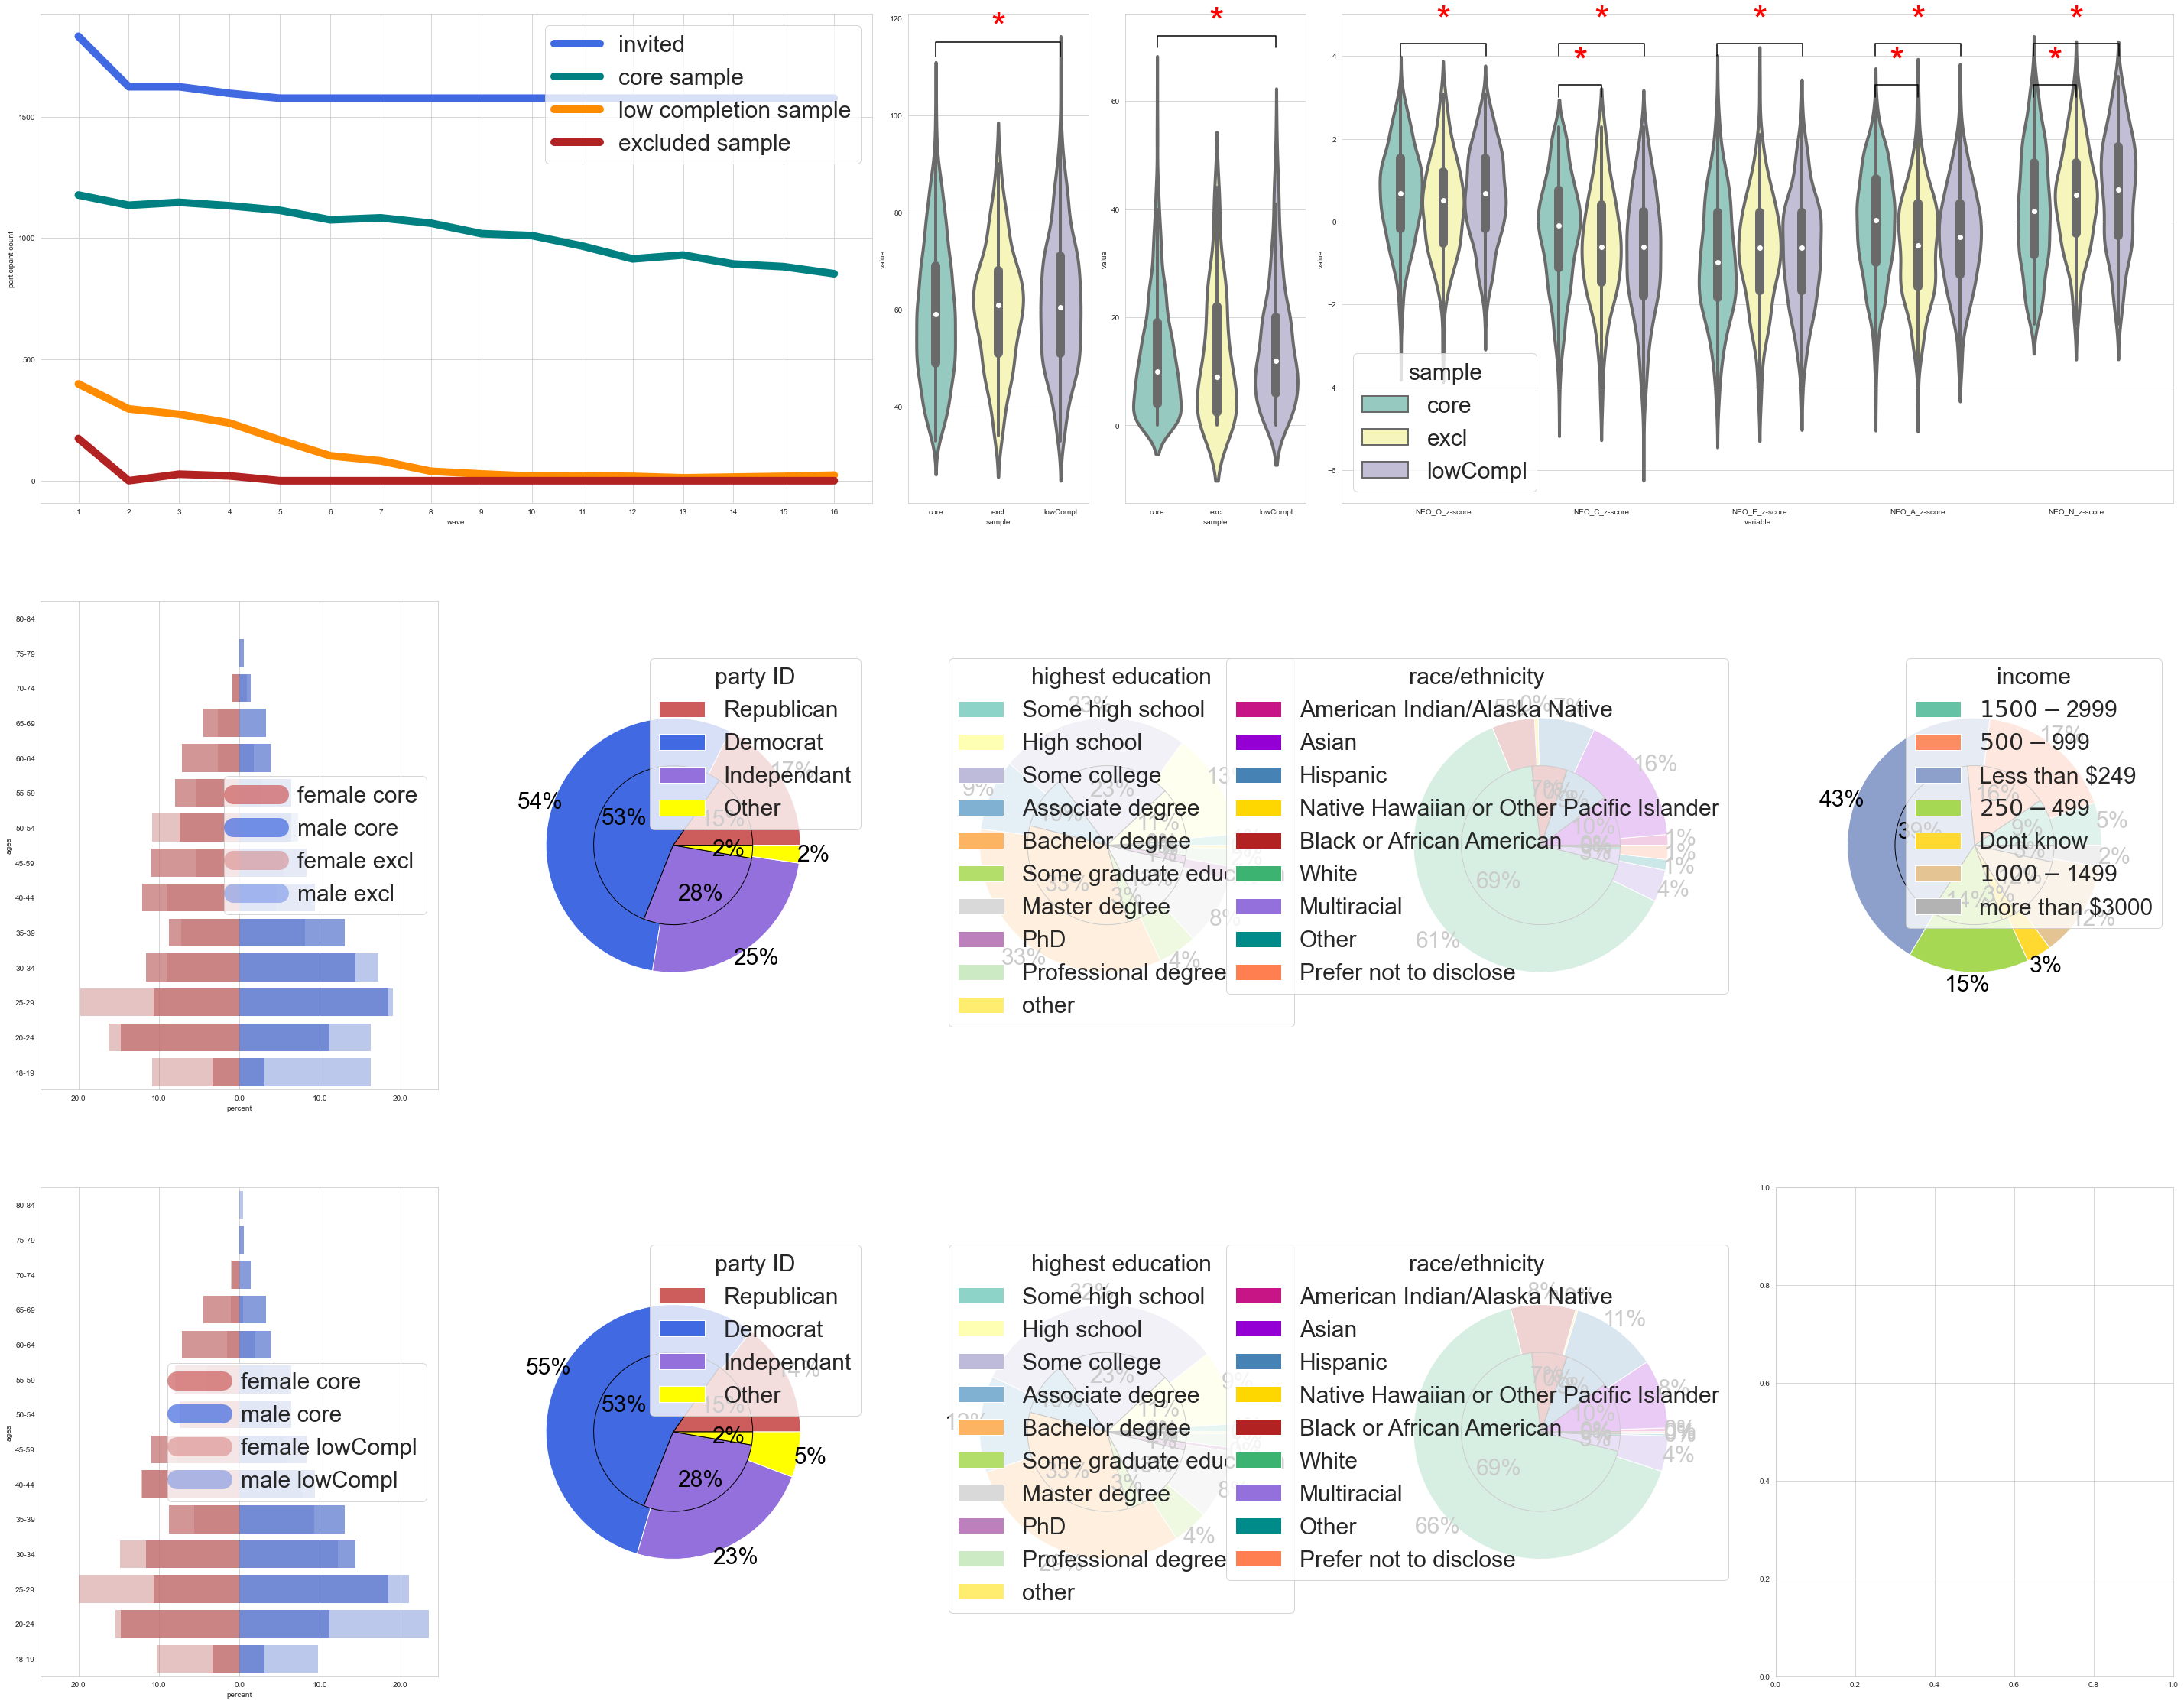

In [23]:
# subplot grid
fig = plt.figure(figsize=(50,40))
sns.set_style("whitegrid")
gs = fig.add_gridspec(3,10)

# sample count
ax1 = fig.add_subplot(gs[0,:4])

# psych vars
ax2 = fig.add_subplot(gs[0,4])
ax3 = fig.add_subplot(gs[0,5])
ax4 = fig.add_subplot(gs[0,6:])

# dem vars
# excluded
ax5 = fig.add_subplot(gs[1,:2])
ax6 = fig.add_subplot(gs[1,2:4])
ax7 = fig.add_subplot(gs[1,4:6])
ax8 = fig.add_subplot(gs[1,6:8])
ax9 = fig.add_subplot(gs[1,8:])
# low compl
ax10 = fig.add_subplot(gs[2,:2])
ax11 = fig.add_subplot(gs[2,2:4])
ax12 = fig.add_subplot(gs[2,4:6])
ax13 = fig.add_subplot(gs[2,6:8])
ax14 = fig.add_subplot(gs[2,8:])




plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('figure', titlesize=50)  # fontsize of the figure title
plt.rcParams['font.size'] = 30


#### sample count across waves ########
cmap = plt.get_cmap('Dark2')
cmap.colors = cmap.colors[::-1]
sample_count[['invited', 'core', 'low_compl', 'excluded']].plot(ax = ax1, linewidth=10,color = ['royalblue', 'teal','darkorange','firebrick'])
ax1.set_ylabel('participant count')
ax1.set_xticks(list(range(0,16)))
ax1.set_yticks([0, 500, 1000, 1500])
ax1.legend(['invited', 'core sample', 'low completion sample', 'excluded sample'])
ax1.set_xticklabels( map(str, list(range(1,17))) )



##### PSYCH ######
#STAI
sns.violinplot(x="sample", y="value", data=psych_all.loc[psych_all.variable == 'STAI_Trait_Tscore',:], palette = "Set3", ax = ax2,  linewidth=4)
ax2.plot([0, 0, 2, 2], [112, 115, 115, 112], lw=1.5, c='k')
ax2.text(1, 114, "*", ha='center', va='bottom', color='r', fontsize = 50)
# BDI 
sns.violinplot(x="sample", y="value", data=psych_all.loc[psych_all.variable == 'BDI_total_raw',:], palette = "Set3", ax = ax3,   linewidth=4)
ax3.plot([0, 0, 2, 2], [70, 72, 72, 70], lw=1.5, c='k')
ax3.text(1, 71, "*", ha='center', va='bottom', color='r', fontsize = 50)
#NEO
sns.violinplot(x="variable", y="value",hue = 'sample',data=psych_all.loc[psych_all.variable.isin(neo_cols),:],palette = "Set3", ax = ax4,  linewidth=4)
# excl NEO O
ax4.plot([-0.27, -0.27, 0.27, 0.27], [4, 4.3, 4.3, 4], lw=1.5, c='k')
ax4.text(0, 4.38, "*", ha='center', va='bottom', color='r', fontsize = 50)
# excl NEO C
ax4.plot([.73, .73, 1, 1], [3, 3.3, 3.3, 3], lw=1.5, c='k')
ax4.text(0.865, 3.38, "*", ha='center', va='bottom', color='r', fontsize = 50)
# low compl NEO C
ax4.plot([.73, .73, 1.27, 1.27], [4, 4.3, 4.3, 4], lw=1.5, c='k')
ax4.text(1, 4.38, "*", ha='center', va='bottom', color='r', fontsize = 50)
# low compl NEO E
ax4.plot([1.73, 1.73, 2.27, 2.27], [4, 4.3, 4.3, 4], lw=1.5, c='k')
ax4.text(2, 4.38, "*", ha='center', va='bottom', color='r', fontsize = 50)
#excl NEO A
ax4.plot([2.73, 2.73, 3, 3], [3, 3.3, 3.3, 3], lw=1.5, c='k')
ax4.text(2.865, 3.38, "*", ha='center', va='bottom', color='r', fontsize = 50)
# low compl NEO A
ax4.plot([2.73, 2.73, 3.27, 3.27], [4, 4.3, 4.3, 4], lw=1.5, c='k')
ax4.text(3, 4.38, "*", ha='center', va='bottom', color='r', fontsize = 50)
#excl NEO N
ax4.plot([3.73, 3.73, 4, 4], [3, 3.3, 3.3, 3], lw=1.5, c='k')
ax4.text(3.865, 3.38, "*", ha='center', va='bottom', color='r', fontsize = 50)
# low compl NEO N
ax4.plot([3.73, 3.73, 4.27, 4.27], [4, 4.3, 4.3, 4], lw=1.5, c='k')
ax4.text(4, 4.38, "*", ha='center', va='bottom', color='r', fontsize = 50)



##### DEM ######
#age
age_sex_butterfly_plot(prop_age, 'excl', ax5)
age_sex_butterfly_plot(prop_age, 'lowCompl', ax10)

#party
party_colors=['indianred','royalblue','mediumpurple','yellow']
# party exclude pie
nested_pie(prop_party, 'excl', 'core', ax6, 'party ID', party_colors)
# party low completion rate pie
nested_pie(prop_party, 'lowCompl', 'core', ax11, 'party ID', party_colors)

# education
cmap = plt.get_cmap('Set3')
ed_colors = [cmap(i) for i in np.linspace(0, 1, len(education))]
# eduaction exclude pie
nested_pie(prop_education, 'excl', 'core', ax7, 'highest education',ed_colors)
# eduaction low completion rate pie
nested_pie(prop_education, 'lowCompl', 'core', ax12, 'highest education',ed_colors)

# race/ethnicity
race_colors = ['MediumVioletRed','DarkViolet', 'SteelBlue','Gold','FireBrick','MediumSeaGreen','MediumPurple','DarkCyan','Coral']
# race/ethnicity exclude pie
nested_pie(prop_raceEth, 'excl', 'core', ax8, 'race/ethnicity',race_colors)
# race/ethnicity low completion rate pie
nested_pie(prop_raceEth, 'lowCompl', 'core', ax13, 'race/ethnicity',race_colors)

# income
cmap = plt.get_cmap('Set2')
income_colors = [cmap(i) for i in np.linspace(0, 1, len(income))]
# income exclude pie
nested_pie(prop_income,  'excl', 'core', ax9, 'income',income_colors)
# income low completion rate pie
nested_pie(prop_income,  'lowCompl', 'core', ax114, 'income',income_colors)




In [ ]:
fig.savefig('attrition_sample.png')
fig.savefig('attrition_sample.svg')